# Mapping Australia 2019/2020 fires
> An example of usage of BA-Net to map and date the extreme fire events that occured in eastern Australia in the fire season of 2019/2020.

In [ ]:
# local
import pandas as pd
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

from banet.core import ProjectPath
from banet.geo import *
from banet.historical import *

In [ ]:
# local
region = 'AU2020'
tstart = '2019-08-01'
tend = '2020-04-30'
paths = ProjectPath('/srv/australia2020/ba100m')
weight_files = ['banetv0.20-val2017-fold0.pth']
times = pd.date_range(tstart, tend, freq='MS')
Region(region, [146, -39, 154, -26], 0.001).export(paths.config/f'R_{region}.json')

```python
manager = RunManager(paths, region, times, product='VIIRS375')
manager.download_viirs()
# Save hotspots{region}.json file in hotspots folder
manager.preprocess_dataset()
manager.get_preds(weight_files, threshold=0.01, filename=f'ba100m_{region}{times[0].year}')
manager.postprocess(filename=f'ba100m_{region}{times[0].year}', 
                   threshold=0.5, area_epsg=3763, interval_days=5, min_size_pixels=1000)
```

## Results

The following figures are examples of the results that can be produced from the output of BA-Net:

In [ ]:
# local
R = Region.load('/srv/australia2020/ba100m/config/R_AU2020.json')
lon, lat = R.coords()
gdf = open_shp('/srv/australia2020/Australia_Polygon.shp')
data = sio.loadmat('/srv/australia2020/ba100m/outputs/ba100m_AU20202019.mat')

ba = data['burned']
I = ba>=0.5
bd = data['date']
bd[~I] = np.nan
ba[~I] = np.nan

<ipython-input-23-17207daf94e9>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im0 = axes[0].pcolormesh(lon, lat, ba, cmap='jet', zorder=3)
<ipython-input-23-17207daf94e9>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im1 = axes[1].pcolormesh(lon, lat, bd, cmap='RdYlGn_r', zorder=3, vmax=200)


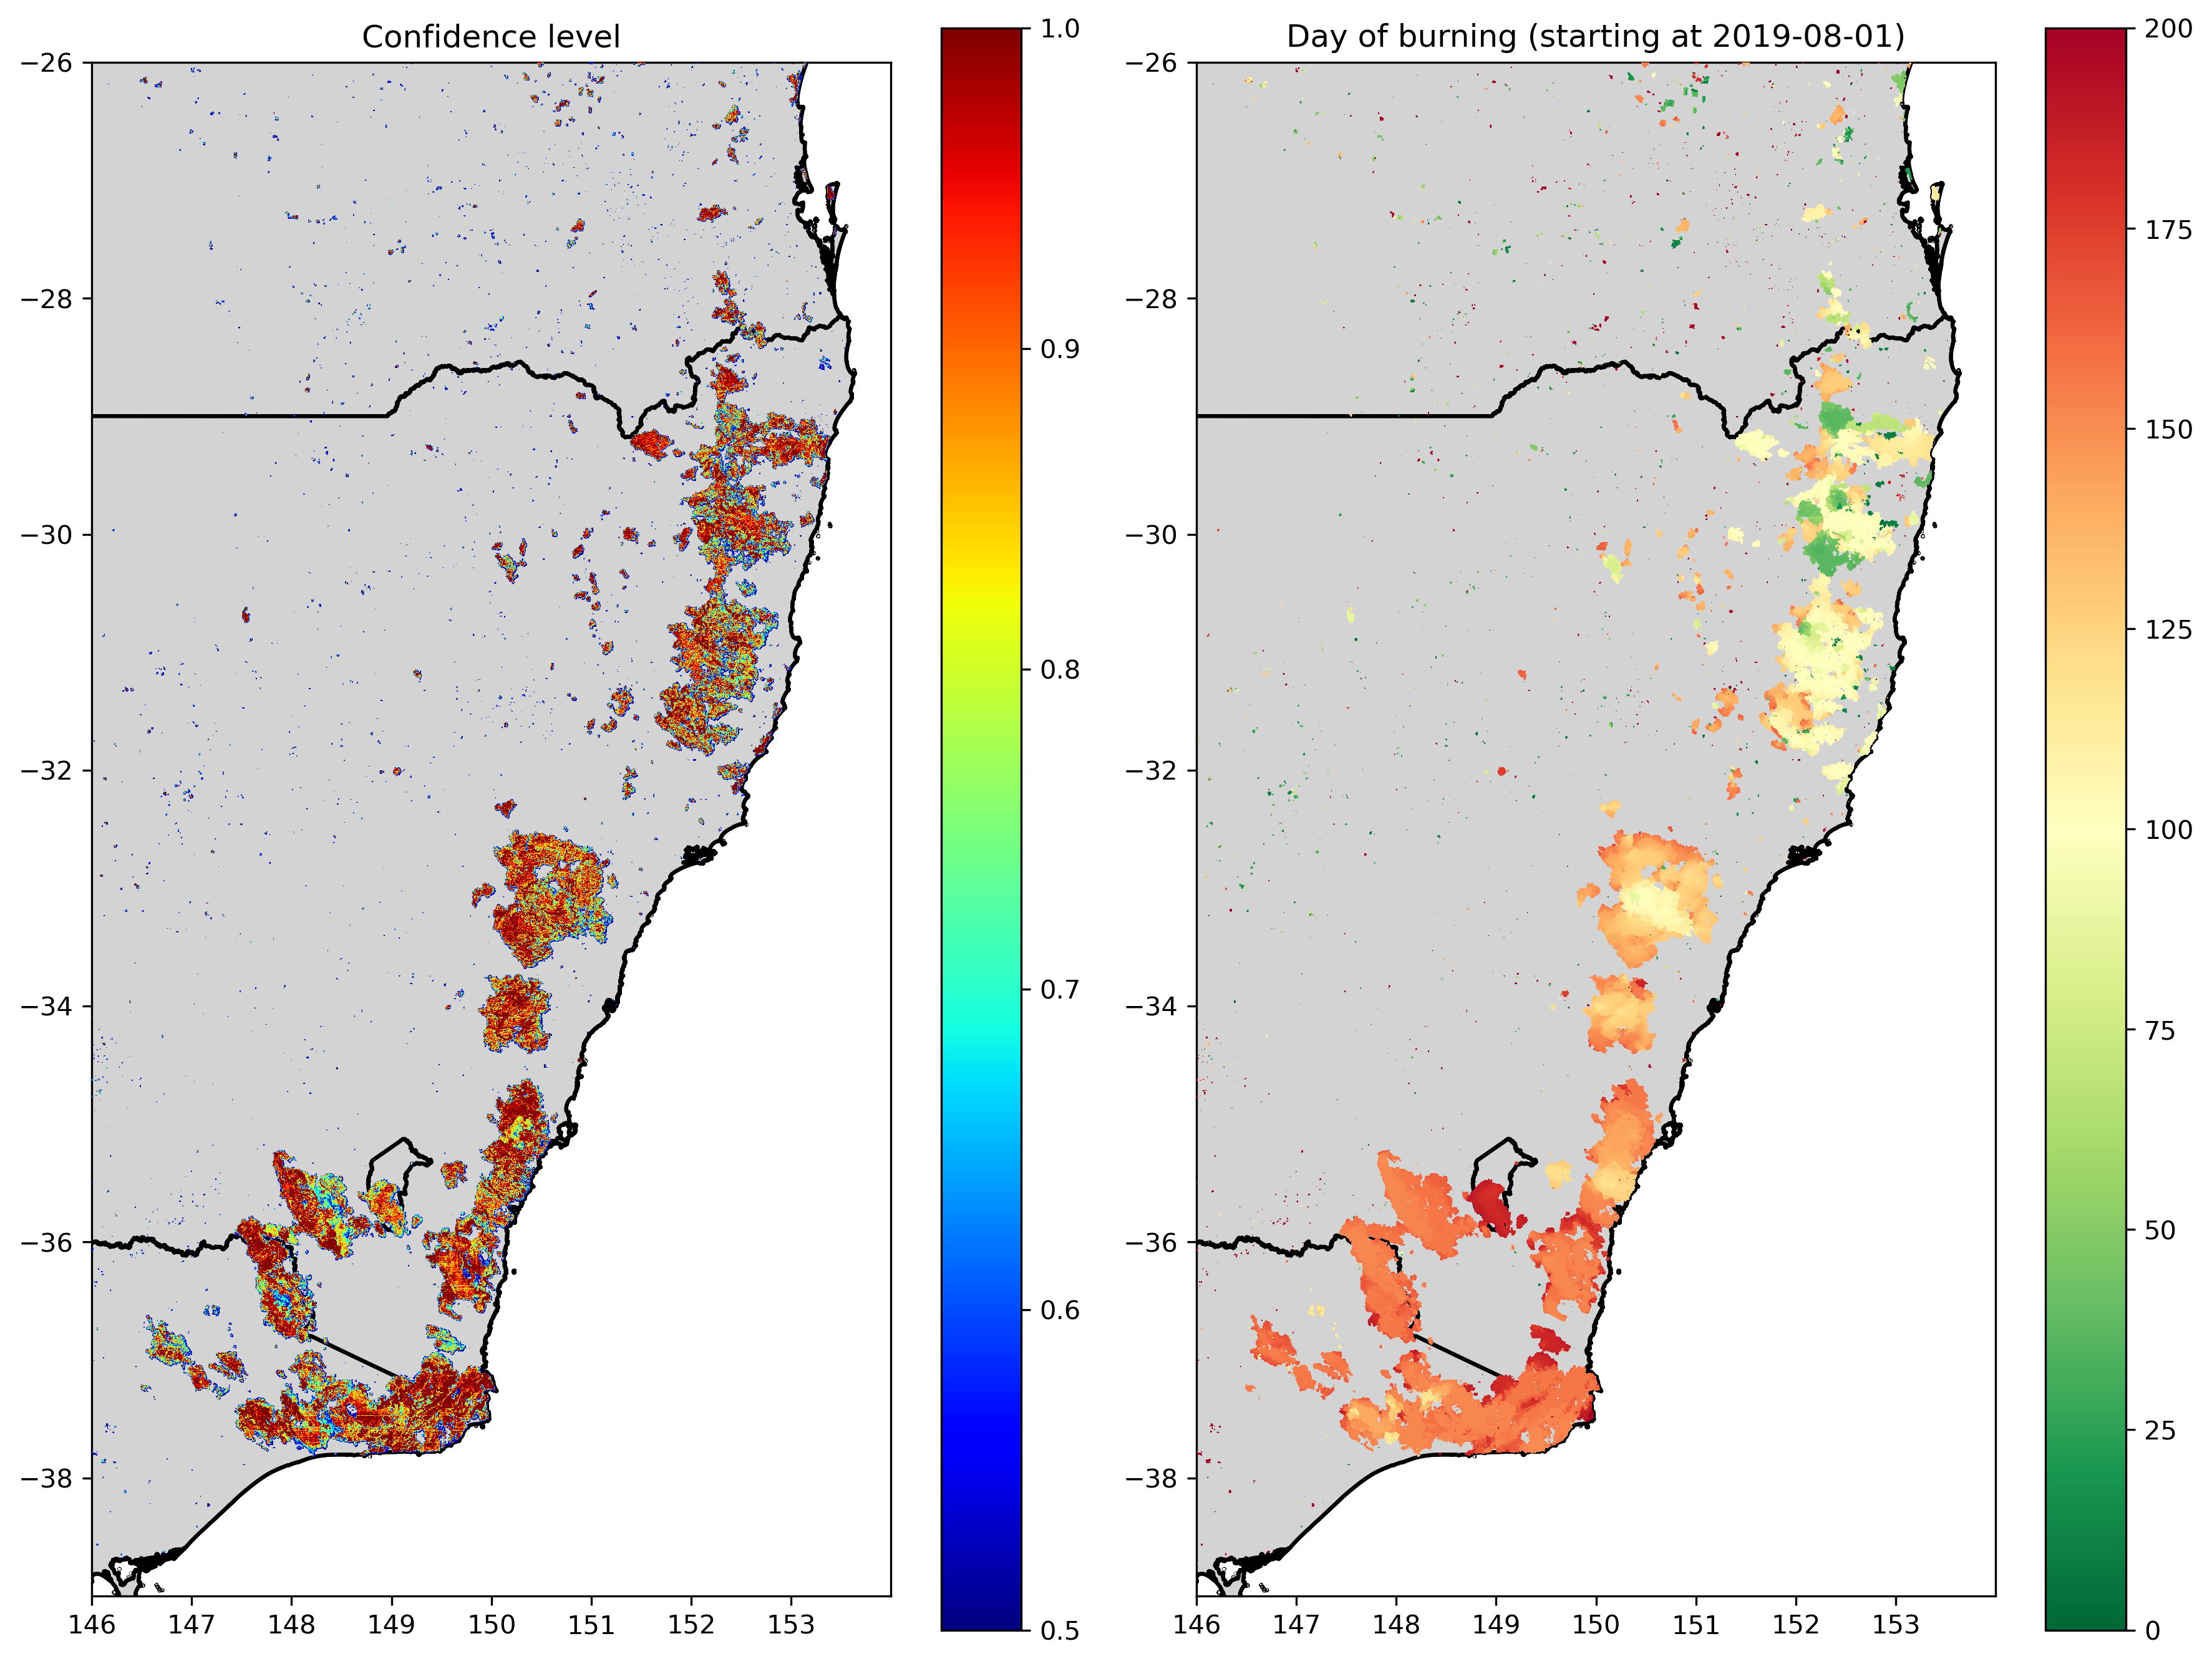

In [ ]:
# local
fig, axes = plt.subplots(ncols=2, figsize=(12,9), dpi=300, facecolor='w')
im0 = axes[0].pcolormesh(lon, lat, ba, cmap='jet', zorder=3)
im1 = axes[1].pcolormesh(lon, lat, bd, cmap='RdYlGn_r', zorder=3, vmax=200)
fig.colorbar(im0, ax=axes[0])
fig.colorbar(im1, ax=axes[1])
axes[0].set_title('Confidence level')
axes[1].set_title('Day of burning (starting at 2019-08-01)')
for ax in axes.flat:
    ax.axis('image')
    axis0 = ax.axis()
    gdf.plot(ax=ax, zorder=1, color='lightgray')
    gdf.boundary.plot(ax=ax, zorder=2, color='k')
    ax.axis(axis0)
fig.tight_layout();

In [ ]:
# local
LON, LAT = np.meshgrid(lon, lat)
dLAT = 0.11111
dLON = dLAT*np.cos(np.deg2rad(LAT))
pix_size = dLON*dLAT

x = list(range(0, np.nanmax(bd).astype(int)))
times = pd.date_range('2019-08-01', '2020-04-30')[:len(x)]
y = [np.nansum(pix_size[bd==i]) for i in x]
df = pd.DataFrame({'times': pd.DatetimeIndex(times), 'freq': y})

(18140.0, 18302.0, 0.0, 5593.6106025249255)

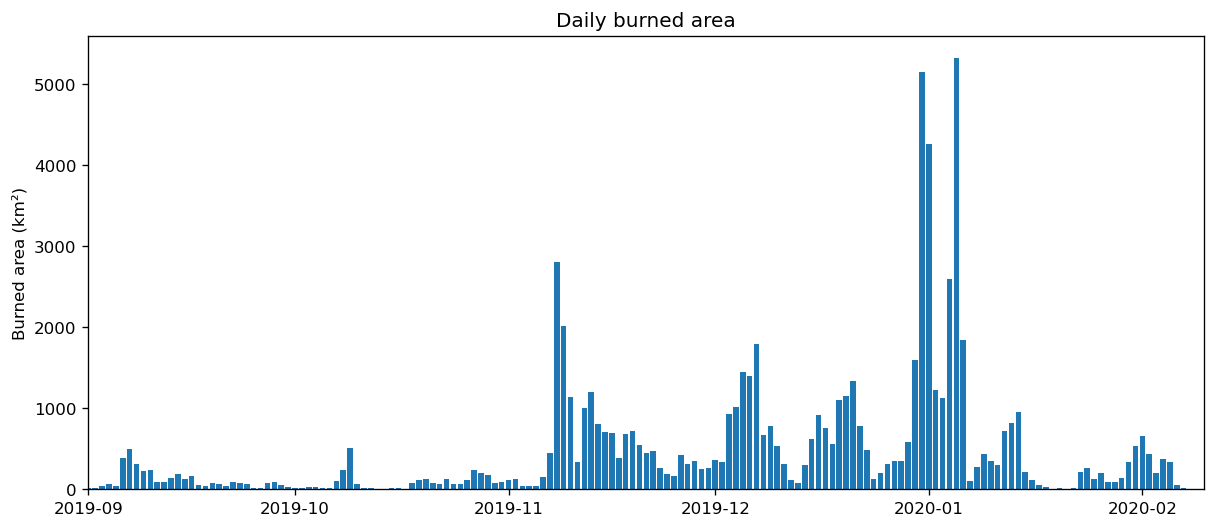

In [ ]:
#local
fig, ax = plt.subplots(figsize=(12,5), dpi=120, facecolor='w')
ax.bar(df.times,df.freq)
ax.set_ylabel('Burned area (km²)')
ax.set_title('Daily burned area');
ax.axis([pd.Timestamp('2019-09-01'), pd.Timestamp('2020-02-10'), None, None])

In [ ]:
# local
print(f'Total burned area: {np.round(np.nansum(df.freq)*100)} ha')